# HaarCascade with face and natural pictures

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import cv2
import dlib
from time import time
import matplotlib.pyplot as plt
import copy
import warnings
from tqdm.notebook import tqdm
from sklearn import metrics
from scipy.stats import chi2_contingency

warnings.filterwarnings('ignore')
cascade_face_detector = cv2.CascadeClassifier('/Users/laurabraadrasmussen/Bachelorprojekt/haarcascade_frontalface_default.xml')

In [2]:
#dataset
df = pd.read_pickle("/Users/laurabraadrasmussen/Bachelorprojekt/df_w_natural.pkl")

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15913 entries, 0 to 15912
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Images                   15913 non-null  object 
 1   Ages                     10000 non-null  float64
 2   Genders                  10000 non-null  float64
 3   Race                     10000 non-null  float64
 4   Caucasien/Non-caucasian  10000 non-null  float64
 5   Label                    15913 non-null  int64  
 6   Folder                   15913 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 870.4+ KB
None


In [4]:
# to array 
images_arr = []
for im in tqdm(range(len(df))): 
    images_arr.append(np.array(df['Images'][im]))

  0%|          | 0/15913 [00:00<?, ?it/s]

In [5]:
images_output = []
for i in tqdm(images_arr):
    if len(i.shape) == 2:
        images_output.append(cv2.cvtColor(i, cv2.COLOR_GRAY2BGR))
    else:
        images_output.append(i)

  0%|          | 0/15913 [00:00<?, ?it/s]

## HaarCascade

In [6]:
def haarCascadeDetectFaces(image, cascade_face_detector, display = True):
    '''
    This function performs face(s) detection on an image using opencv haar cascade face detector.
    Args:
        image:                 The input image of the person(s) whose face needs to be detected.
        cascade_face_detector: The pre-trained Haar cascade face detection model loaded from the disk required to 
                               perform the detection.
        display:               A boolean value that is if set to true the function displays the original input image, 
                               and the output image with the bounding boxes drawn and time taken written and returns 
                               nothing.
    Returns:
        output_image: A copy of input image with the bounding boxes drawn.
        results:      The output of the face detection process on the input image.
    '''
    
    # Get the height and width of the input image.
    image_height, image_width, _ = image.shape
    
    # Create a copy of the input image to draw bounding boxes on.
    output_image = image.copy()
    
    # Convert the input image to grayscale.
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Get the current time before performing face detection. 
    start = time()
 
    # Perform the face detection on the image.
    results = cascade_face_detector.detectMultiScale(image=gray, scaleFactor=1.2, minNeighbors=3)
    
    # Get the current time after performing face detection.
    end = time()
 
    # Loop through each face detected in the image and retireve the bounding box cordinates.
    for (x1, y1, bbox_width, bbox_height) in results:
 
        # Draw bounding box around the face on the copy of the input image using the retrieved coordinates.
        cv2.rectangle(output_image, pt1=(x1, y1), pt2=(x1 + bbox_width, y1 + bbox_height), color=(0, 255, 0),
                      thickness=image_width//200)
    
    # Check if the original input image and the output image are specified to be displayed.
    if display:
        
        # Write the time take by face detection process on the output image. 
        cv2.putText(output_image, text='Time taken: '+str(round(end - start, 2))+' Seconds.', org=(10, 65),
                    fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=image_width//700, color=(0,0,255),
                    thickness=image_width//500)
        
        # Display the original input image and the output image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output");plt.axis('off');
        
    # Otherwise
    else:
        
        # Return the output image and results of face detection.
        return cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR), results

In [7]:
haarCascade = [haarCascadeDetectFaces(images_output[i], cascade_face_detector, display = False) for i in tqdm(range(len(images_output)))]

  0%|          | 0/15913 [00:00<?, ?it/s]

In [8]:
df['Predicted'] = 3

In [9]:
Predicted = [] #[0 if len(haarCascade[i][1]) == 0 else 1 for i in range(len(haarCascade))]

for i in range(len(haarCascade)):
    if len(haarCascade[i][1]) == 0:
        df['Predicted'].iloc[i] = 0
    else:
        df['Predicted'].iloc[i]  = 1

## Confusion matrix

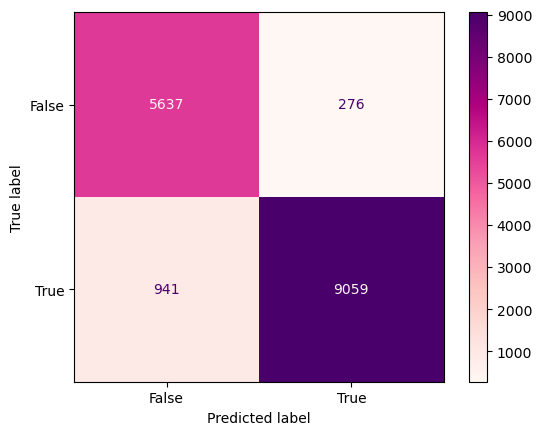

In [16]:
Confusion_matrix = metrics.confusion_matrix(Actual, Predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = Confusion_matrix, display_labels = [False, True] )
cm_display.plot(cmap = 'RdPu')
plt.show()

In [17]:
#investigation of false positives
#df[(df['Label'] == 0 ) & (df['Predicted']==1)]

## Evaluation

In [10]:
Actual = df['Label']
Predicted = df['Predicted']

In [11]:
Accuracy  = metrics.accuracy_score(Actual, Predicted)
Accuracy

0.923521648966254

In [12]:
Precision = metrics.precision_score(Actual, Predicted) # true positive rate 
Precision

0.9704338510980182

In [13]:
Sensitivity = metrics.recall_score(Actual, Predicted)
Sensitivity

0.9059

In [14]:
Specificity = metrics.recall_score(Actual, Predicted, pos_label = 0)
Specificity

0.9533231861998985

In [15]:
F_score = metrics.f1_score(Actual, Predicted)
F_score

0.9370571502456686

## Dataframe of the not detected faces

In [19]:
not_dect_index = [i for i in range(len(haarCascade)) if (len(haarCascade[i][1]) == 0)&( df['Folder'][i] == 'Person')] #without the natural pic
not_dect_images = [df['Images'][i] for i in not_dect_index]
not_dect_ages = [df['Ages'][i] for i in not_dect_index]
not_dect_genders = [df['Genders'][i] for i in not_dect_index]
not_dect_races = [df['Race'][i] for i in not_dect_index]
not_dect_caucasian = [df['Caucasien/Non-caucasian'][i] for i in not_dect_index]
#not_dect_time = [pd.Timedelta(haarCascade[i][2], unit='minutes') for i in not_dect_index]

df_not_detected = pd.DataFrame({
    'not_dect_index': not_dect_index,
    'not_dect_images': not_dect_images,
    'not_dect_ages': not_dect_ages,
    'not_dect_genders': not_dect_genders,
    'not_dect_races': not_dect_races,
    'not_dect_caucasian': not_dect_caucasian,
    #'not_dect_time': not_dect_time
})

## Chi 2 testing

In [23]:
# Create a contingency table
df_person = df[df['Folder']=='Person']
unique_race, counts = np.unique(df_person['Race'], return_counts=True)
counts_dict = dict(zip(unique_race, counts))


detected = []   # Frequencies of detected faces in each group
not_detected = []   # Frequencies of not detected faces in each group
for i in unique_race:
    detected.append(counts_dict[i]- len(df_not_detected[df_not_detected["not_dect_races"] == i]))
    not_detected.append(len(df_not_detected[df_not_detected["not_dect_races"] == i]))

# Perform the chi-square test
observed = [detected, not_detected]
chi2, p, dof, expected = chi2_contingency(observed)

# chi2: The chi-square test statistic
# p: The p-value
# dof: Degrees of freedom
# expected: The expected frequencies under the null hypothesis

# Print the results
print("Chi-square test statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)

Chi-square test statistic: 125.76779991926817
p-value: 4.415774774781324e-27
Degrees of freedom: 3
Expected frequencies: [[2264.75 2264.75 2264.75 2264.75]
 [ 235.25  235.25  235.25  235.25]]


## True positives

In [24]:
df_person = df[df['Folder']=='Person']
unique_race, counts = np.unique(df_person['Race'], return_counts=True)
counts_dict = dict(zip(unique_race, counts))

percentage_r = [((counts_dict[i]-(len(df_not_detected[df_not_detected["not_dect_races"] == i]))) / counts_dict[i])for i in unique_race]
percentage_r

[0.9408, 0.884, 0.864, 0.9348]

In [25]:
#test against threshold 80%
min(percentage_r)/max(percentage_r)


0.9183673469387755

## Distribution in not detected faces

In [49]:
unique_race, counts = np.unique(df_not_detected['not_dect_races'], return_counts=True)
counts_dict = dict(zip(unique_race, counts))
dist = counts/sum(counts)*100

In [ ]:
counts_dict

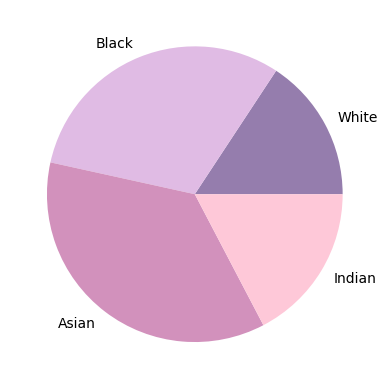

In [50]:
labels = ['White','Black','Asian','Indian']
colors = ['#957DAD','#E0BBE4','#D291BC','#FEC8D8']
plt.pie(dist, labels = labels, colors = colors)
plt.show()

## Bar plots
## Race

In [51]:
unique_race, counts = np.unique(df_person['Race'], return_counts=True)
counts_dict = dict(zip(unique_race, counts))

percentage_r = [(len(df_not_detected[df_not_detected["not_dect_races"] == i]) / counts_dict[i]) * 100 for i in unique_race]

In [52]:
percentage_r

[5.92, 11.600000000000001, 13.600000000000001, 6.52]

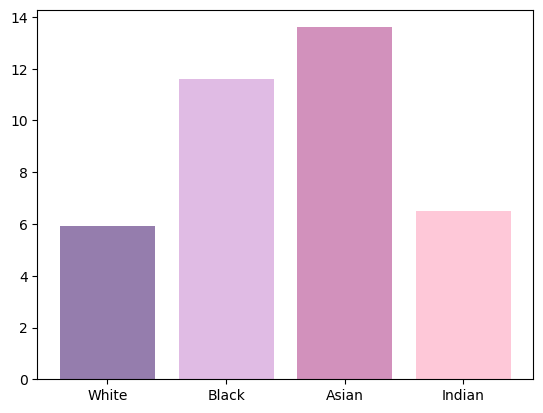

In [53]:
labels = ['White','Black','Asian','Indian']
colors = ['#957DAD','#E0BBE4','#D291BC','#FEC8D8']
plt.bar(list(unique_race), percentage_r, color = colors)
plt.xticks(list(unique_race), labels)
plt.show()

### Køn

In [54]:
unique_gender, counts = np.unique(df_person['Genders'], return_counts=True)
counts_dict = dict(zip(unique_gender, counts))

percentage_g = [(len(df_not_detected[df_not_detected["not_dect_genders"] == i]) / counts_dict[i]) * 100 for i in unique_gender]

In [55]:
percentage_g

[9.165867689357622, 9.676071055381401]

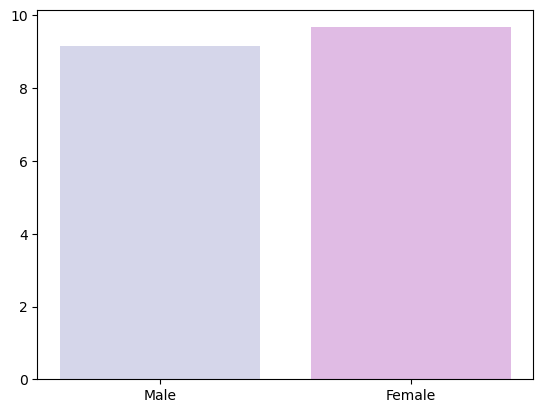

In [56]:
colors = ['#D5D6EA','#E0BBE4']
plt.bar(list(unique_gender), percentage_g, color = colors)
plt.xticks(list(unique_gender), ['Male', 'Female'])
plt.show()

### Caucasian

In [57]:
unique_caucasian, counts = np.unique(df_person['Caucasien/Non-caucasian'], return_counts=True)
counts_dict = dict(zip(unique_caucasian, counts))
percentage_c = [(len(df_not_detected[df_not_detected["not_dect_caucasian"] == i]) / counts_dict[i]) * 100 for i in unique_caucasian]

In [58]:
percentage_c

[5.92, 10.573333333333332]

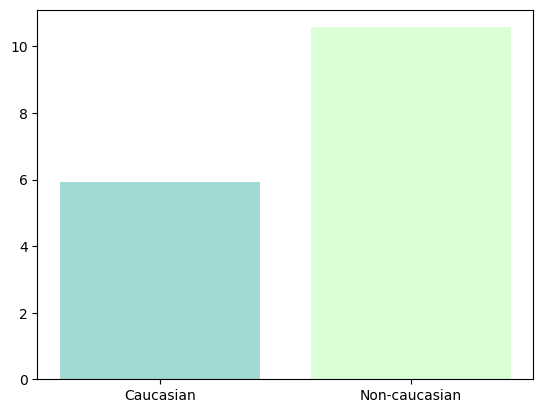

In [62]:
colors = ['#A0D9D4', '#DBFFD6']
labels = ['Caucasian', 'Non-caucasian']
plt.bar(list(unique_caucasian), percentage_c,  color = colors)
plt.xticks(list(unique_caucasian), labels)
plt.show()

### Alder

In [60]:
unique_ages, counts = np.unique(df_person['Ages'], return_counts=True)
counts_dict = dict(zip(unique_ages, counts))
percentage_a = [(len(df_not_detected[df_not_detected["not_dect_ages"] == i]) / counts_dict[i]) * 100 for i in unique_ages]



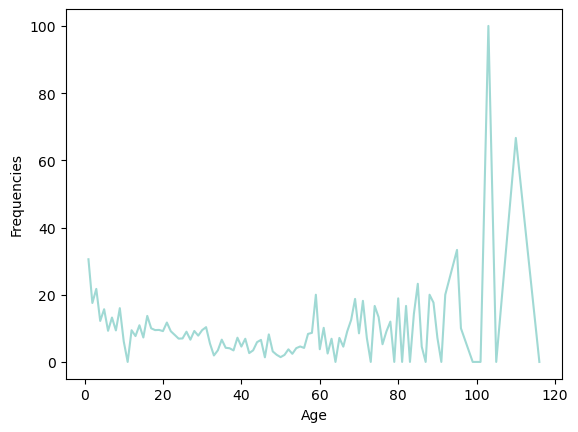

In [61]:
plt.plot(list(unique_ages), percentage_a, color = '#A0D9D4')
plt.xlabel('Age')
plt.ylabel('Frequencies')

plt.show()